# Botnet Detection using Deep learning approaches

### Importing Dataset

In [1]:

from google.colab import files
files.upload()


Mounted at /content/drive


'\nfrom google.colab import files\nfiles.upload()\n'

### Pre-processing the Dataset

In [21]:
# Import required packages

import numpy as np  # linear algebra
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from PIL import Image
import random
import pickle
import cv2
import datetime
from pprint import pprint
import librosa
from itertools import cycle


from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support,  roc_curve, auc

import keras
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.regularizers import *
from keras.initializers import glorot_uniform

import keras.backend as K
K.clear_session()

from keras.models import *
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
from keras.callbacks import *

In [22]:


data=pd.read_csv('/content/drive/My Drive/Train_Test_Network.csv')

data

,ts,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,1554198358,3.122.49.24,1883,192.168.1.152,52976,tcp,-,80549.530260,1762852,41933215,...,0,0,-,-,-,bad_TCP_checksum,-,F,0,normal
1,1554198358,192.168.1.79,47260,192.168.1.255,15600,udp,-,0.000000,0,0,...,0,0,-,-,-,-,-,-,0,normal
2,1554198359,192.168.1.152,1880,192.168.1.152,51782,tcp,-,0.000000,0,0,...,0,0,-,-,-,bad_TCP_checksum,-,F,0,normal
3,1554198359,192.168.1.152,34296,192.168.1.152,10502,tcp,-,0.000000,0,0,...,0,0,-,-,-,-,-,-,0,normal
4,1554198362,192.168.1.152,46608,192.168.1.190,53,udp,dns,0.000549,0,298,...,0,0,-,-,-,bad_UDP_checksum,-,F,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461038,1556340862,192.168.1.32,33108,176.28.50.165,80,tcp,-,0.000000,0,0,...,0,0,-,-,-,-,-,-,1,xss
461039,1556423390,192.168.1.33,37242,34.230.157.88,443,tcp,-,0.000000,0,0,...,0,0,-,-,-,-,-,-,1,ransomware
461040,1556436603,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,...,0,0,-,-,-,-,-,-,1,backdoor
461041,1556540442,192.168.1.31,60816,104.98.29.100,443,tcp,-,23.190902,32,31,...,0,0,-,-,-,-,-,-,1,mitm


In [23]:
# Shuffling the rows of dataframe 

sampler=np.random.permutation(len(data))

data=data.take(sampler)
print(data.shape)

(461043, 45)


In [24]:
# Dummy encode labels and stored separately

labels_full=pd.get_dummies(data['type'], prefix='type')
labels_full.head()

,type_backdoor,type_ddos,type_dos,type_injection,type_mitm,type_normal,type_password,type_ransomware,type_scanning,type_xss
235902,0,0,0,0,0,1,0,0,0,0
324566,0,0,0,0,0,0,1,0,0,0
386433,0,0,0,0,0,1,0,0,0,0
19885,0,0,0,0,0,1,0,0,0,0
416651,0,0,0,0,0,1,0,0,0,0


In [25]:
# Extracting required features from the Dataset

data=data[['ts', 'src_port', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes']]
data.head()


,ts,src_port,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes
235902,1556248537,58054,53,udp,dns,0.000758,0,566,SHR,0,0,0,2,622
324566,1556287572,60780,80,tcp,-,0.000142,0,0,REJ,0,1,60,1,40
386433,1556349852,61599,1900,udp,-,3.356777,3016,0,S0,0,24,3688,0,0
19885,1554226121,42100,7878,tcp,-,0.000000,0,0,OTH,0,0,0,0,0
416651,1556423583,9197,49822,tcp,-,0.000000,0,0,OTH,0,1,40,0,0


In [26]:

data1=pd.get_dummies(data=data, columns=['conn_state','proto', 'service'])

data1.head()

,ts,src_port,dst_port,duration,src_bytes,dst_bytes,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,...,service_-,service_dce_rpc,service_dhcp,service_dns,service_ftp,service_gssapi,service_http,service_smb,service_smb;gssapi,service_ssl
235902,1556248537,58054,53,0.000758,0,566,0,0,0,2,...,0,0,0,1,0,0,0,0,0,0
324566,1556287572,60780,80,0.000142,0,0,0,1,60,1,...,1,0,0,0,0,0,0,0,0,0
386433,1556349852,61599,1900,3.356777,3016,0,0,24,3688,0,...,1,0,0,0,0,0,0,0,0,0
19885,1554226121,42100,7878,0.000000,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
416651,1556423583,9197,49822,0.000000,0,0,0,1,40,0,...,1,0,0,0,0,0,0,0,0,0


In [27]:

# Data Standardization

def standardize(df,col):
    df[col]= (df[col]-df[col].mean())/df[col].std()


data_st=data1.copy()
for i in (data_st.iloc[:,].columns):
    standardize (data_st,i)

data_st.head()

,ts,src_port,dst_port,duration,src_bytes,dst_bytes,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,...,service_-,service_dce_rpc,service_dhcp,service_dns,service_ftp,service_gssapi,service_http,service_smb,service_smb;gssapi,service_ssl
235902,0.660635,1.013977,-0.552686,-0.018484,-0.010455,-0.009767,-0.004464,-0.013855,-0.010581,-0.008149,...,-1.244842,-0.017178,-0.009989,1.719920,-0.048118,-0.019981,-0.389458,-0.015307,-0.006248,-0.067157
324566,0.701901,1.161572,-0.550750,-0.018485,-0.010455,-0.009813,-0.004464,-0.011924,-0.010232,-0.009436,...,0.803313,-0.017178,-0.009989,-0.581421,-0.048118,-0.019981,-0.389458,-0.015307,-0.006248,-0.067157
386433,0.767742,1.205916,-0.420224,-0.011163,-0.010194,-0.009813,-0.004464,0.032482,0.010855,-0.010723,...,0.803313,-0.017178,-0.009989,-0.581421,-0.048118,-0.019981,-0.389458,-0.015307,-0.006248,-0.067157
19885,-1.477399,0.150173,0.008502,-0.018486,-0.010455,-0.009813,-0.004464,-0.013855,-0.010581,-0.010723,...,0.803313,-0.017178,-0.009989,-0.581421,-0.048118,-0.019981,-0.389458,-0.015307,-0.006248,-0.067157
416651,0.845688,-1.631309,3.016615,-0.018486,-0.010455,-0.009813,-0.004464,-0.011924,-0.010349,-0.010723,...,0.803313,-0.017178,-0.009989,-0.581421,-0.048118,-0.019981,-0.389458,-0.015307,-0.006248,-0.067157


In [28]:
# Feature Selection 

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        
        
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr


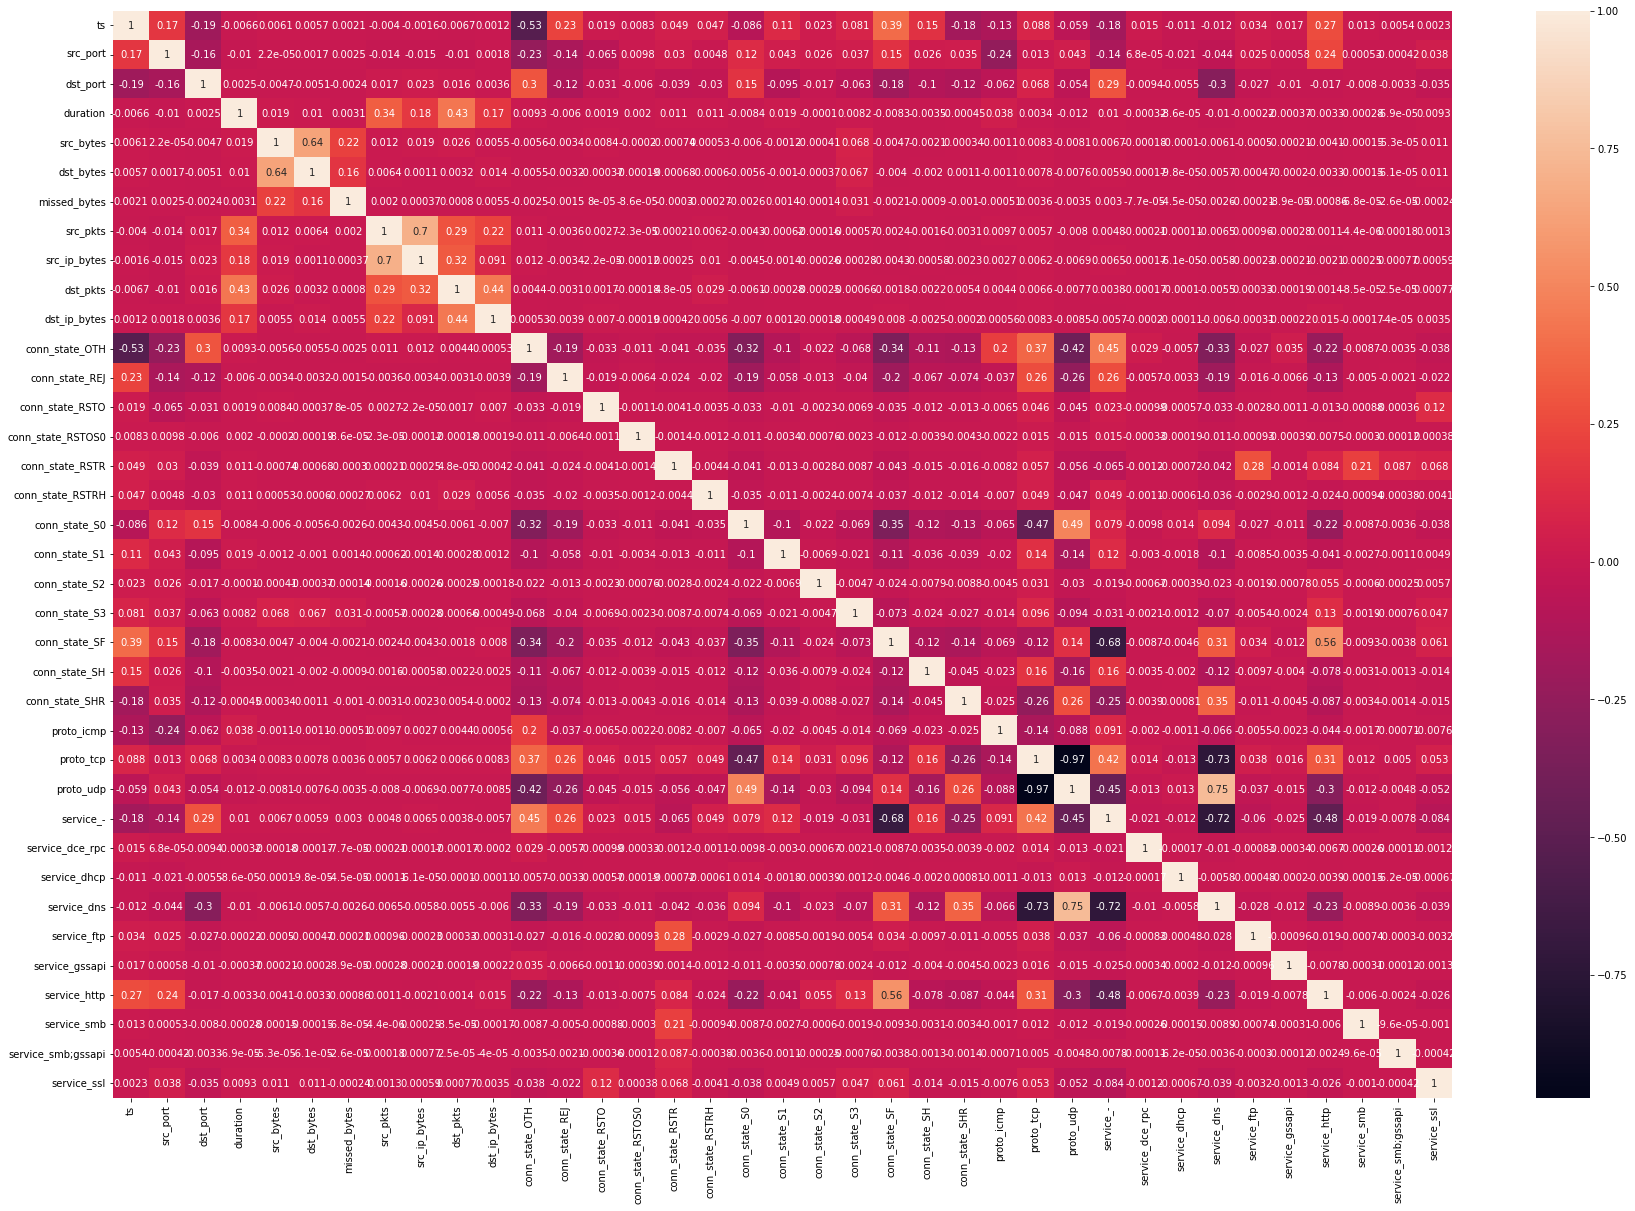

In [29]:

#Using Pearson Correlation
plt.figure(figsize=(30,20))
cor = data_st.corr()
sns.heatmap(cor, annot=True)
plt.show()

In [30]:
corr_features = correlation(data_st, 0.9)
data_st = data_st.drop(corr_features,axis=1)

In [36]:
# Focal Loss for Class Imbalance

# Compatible with tensorflow backend

def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
	return focal_loss_fixed

In [31]:
train_data_st=data_st.values
train_data_st

array([[ 0.66063487,  1.01397712, -0.55268595, ..., -0.01530705,
        -0.00624847, -0.06715698],
       [ 0.70190142,  1.16157217, -0.55074958, ..., -0.01530705,
        -0.00624847, -0.06715698],
       [ 0.76774185,  1.20591565, -0.42022399, ..., -0.01530705,
        -0.00624847, -0.06715698],
       ...,
       [-1.41441263, -0.06737584,  0.56230384, ..., -0.01530705,
        -0.00624847, -0.06715698],
       [ 0.77484602,  1.16270918, -0.17244051, ..., -0.01530705,
        -0.00624847, -0.06715698],
       [-1.43484875,  1.08560891,  0.56230384, ..., -0.01530705,
        -0.00624847, -0.06715698]])

In [32]:
# Labels for training

labels=labels_full.values
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [54]:
# Validation Technique

# Splitting the Data for Training(70%) and Testing(30%) the model
x_train, x_test, y_train, y_test = train_test_split(train_data_st, labels, test_size=0.3)

# Splitting the Training Data for Training(87.5%) and Validating(12.5%) the model
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.125)

print(x_train.shape)
print(x_test.shape)
print(x_validate.shape)

(282388, 36)
(138313, 36)
(40342, 36)


### Neural Network Models

##### CNN-LSTM Model

In [34]:
model1 = Sequential()
model1.add(Conv1D(filters=64, kernel_size=5, strides=1, padding='same', input_shape = (train_data_st.shape[1], 1)))
model1.add(Conv1D(filters=32, kernel_size=5, strides=1, padding='same'))
model1.add(LSTM(32, activation = 'relu', return_sequences=True))
model1.add(LSTM(16, return_sequences=True))  # returns a sequence of vectors of dimension 16
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu'))

model1.add(Dense(labels.shape[1],activation='softmax'))

model1Name = 'CNN+LSTM'
keras.utils.vis_utils.plot_model(model1, './'+model1Name+'_Archi.png',show_shapes=True)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 64)            384       
                                                                 
 conv1d_1 (Conv1D)           (None, 36, 32)            10272     
                                                                 
 lstm (LSTM)                 (None, 36, 32)            8320      
                                                                 
 lstm_1 (LSTM)               (None, 36, 16)            3136      
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 128)               73856     
                                                                 
 dense_1 (Dense)             (None, 64)                8

##### DRCNN Model

In [35]:
# Building 5 block of residual Convolutional layer

inp = Input(shape=(train_data_st.shape[1], 1))
C = Conv1D(filters=64, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=3, strides=2)(A12)


C21 = Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=3, strides=2)(A22)


C31 = Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=3, strides=2)(A32)


C41 = Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=3, strides=2)(A42)


C51 = Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=64, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=3, strides=2)(A52)

F1 = Flatten()(M51) #m51

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(labels.shape[1])(D2)
A7 = Activation("softmax")(D3)

model2 = Model(inputs=inp, outputs=A7)


keras.utils.vis_utils.plot_model(model2, './Deep_residual_CNN_model.png', show_shapes=True)

model2Name='Deep residual CNN'

model2.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 1)]      0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 32, 64)       384         ['input_1[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 32, 64)       20544       ['conv1d_2[0][0]']               
                                                                                                  
 activation (Activation)        (None, 32, 64)       0           ['conv1d_3[0][0]']               
                                                                                              

### Training the Models

In [37]:
# Function to compile and fit the model


def model_val(model, modelName):
    adam = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss=[focal_loss(alpha=.25, gamma=2)], optimizer=adam, metrics=['accuracy'])
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, 
                                                factor=0.5, 
                                                learning_rate=0.00001)
    
    earlystop = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 10,
                              verbose = 1,
                              restore_best_weights = True)

    checkpoint = ModelCheckpoint('./'+modelName+'.h5',
                                monitor='val_loss',
                                mode='min',
                                save_best_only=True,
                                save_weights_only=True,
                                verbose=1)
    
    history = model.fit(x_train,y_train, batch_size=batch_size,
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    callbacks=[learning_rate_reduction, checkpoint]
    )


    plot_model_history(history, modelName)
    with open('./History_'+modelName, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [38]:
# Function to plot model's validation loss and validation accuracy

def plot_model_history(model_history, modelName):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1), model_history.history['accuracy'], '--*', color = (1,0,0))
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1), model_history.history['val_accuracy'], '-^', color = (0.7,0,0.7))
    axs[0].set_title('Model '+modelName+' Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[0].grid('on')
    
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1), model_history.history['loss'],'-x', color = (0,0.5,0))
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1), model_history.history['val_loss'],  '-.D', color = (0,0,0.5))
    axs[1].set_title('Model '+modelName+' Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    axs[1].grid('on')
    plt.savefig('./'+modelName+'.jpg',dpi=600, quality = 100, optimize = True)
    plt.show()


Epoch 1/70
551/551 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 0.8643
Epoch 1: val_loss improved from inf to 0.00533, saving model to ./CNN+LSTM.h5
551/551 [==============================] - 83s 145ms/step - loss: 0.0084 - accuracy: 0.8643 - val_loss: 0.0053 - val_accuracy: 0.9236 - lr: 0.0010
Epoch 2/70
551/551 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9626
Epoch 2: val_loss improved from 0.00533 to 0.00104, saving model to ./CNN+LSTM.h5
551/551 [==============================] - 83s 151ms/step - loss: 0.0025 - accuracy: 0.9626 - val_loss: 0.0010 - val_accuracy: 0.9863 - lr: 0.0010
Epoch 3/70
551/551 [==============================] - ETA: 0s - loss: 9.4138e-04 - accuracy: 0.9853
Epoch 3: val_loss improved from 0.00104 to 0.00055, saving model to ./CNN+LSTM.h5
551/551 [==============================] - 79s 144ms/step - loss: 9.4138e-04 - accuracy: 0.9853 - val_loss: 5.5244e-04 - val_accuracy: 0.9908 - lr: 0.0010
Epoch 4/70
551/55

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


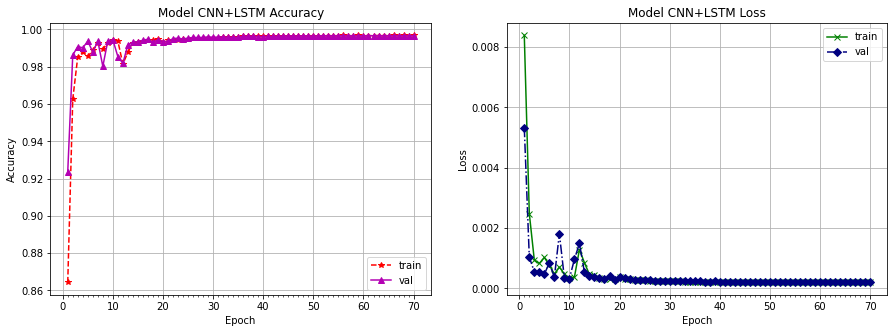

In [39]:
epochs = 70
batch_size = 512

# Training CNN-LSTM model

model_val(model1, model1Name)



Epoch 1/70
551/551 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.8508
Epoch 1: val_loss improved from inf to 0.00536, saving model to ./Deep residual CNN.h5
551/551 [==============================] - 127s 228ms/step - loss: 0.0095 - accuracy: 0.8508 - val_loss: 0.0054 - val_accuracy: 0.9240 - lr: 0.0010
Epoch 2/70
551/551 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9662
Epoch 2: val_loss improved from 0.00536 to 0.00082, saving model to ./Deep residual CNN.h5
551/551 [==============================] - 126s 228ms/step - loss: 0.0024 - accuracy: 0.9662 - val_loss: 8.2114e-04 - val_accuracy: 0.9884 - lr: 0.0010
Epoch 3/70
551/551 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9817
Epoch 3: val_loss improved from 0.00082 to 0.00071, saving model to ./Deep residual CNN.h5
551/551 [==============================] - 125s 227ms/step - loss: 0.0013 - accuracy: 0.9817 - val_loss: 7.1186e-04 - val_accuracy: 0.9904 - lr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


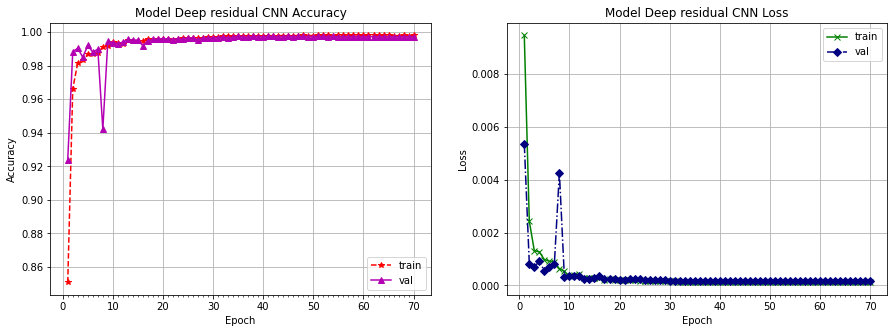

In [40]:
# Training Deep residual CNN model

model_val(model2, model2Name)


### Testing the Models

In [56]:
# Function to test the models and calculate the Evaluation metrics


def eval_metrics(model, modelName):

    y_pred = model.predict(x_test)

    y_pred_cm  = np.argmax(y_pred, axis=1)
    y_test_cm  = np.argmax(y_test, axis=1)

    # Confusion matrix for the model
    cm = confusion_matrix(y_test_cm, y_pred_cm) 

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(10,10)
    #labels = np.asarray(labels).reshape(2,2)
    label = ['backdoor', 'ddos', 'dos', 'injection', 'mitm', 'normal', 'password', 'ransomware', 'scanning', 'xss']  
    #label = ['normal','malware']
    plt.figure(figsize=(10,10))
    #plt.figure(figsize=(2,2))
    sns.heatmap(cm, xticklabels=label, yticklabels=label, annot=labels, fmt='', cmap="Blues", vmin = 0.2);
    plt.title('Confusion Matrix for '+ modelName+' model')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.savefig('./'+modelName+'_CM.png')
    plt.show()

    # Creating Classification Report with Accuracy and Precision of the model
    print(classification_report(y_test_cm, y_pred_cm, target_names= ['backdoor', 'ddos', 'dos', 'injection', 'mitm', 'normal', 'password', 'ransomware', 'scanning', 'xss'], digits=4))
    #print(classification_report(y_test_cm, y_pred_cm, target_names= ['normal','malware']))
    loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
    print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
    with open('./'+modelName+'_CR.txt','a') as f:
      f.write(classification_report(y_test_cm, y_pred_cm, target_names= ['backdoor', 'ddos', 'dos', 'injection', 'mitm', 'normal', 'password', 'ransomware', 'scanning', 'xss']))
      #f.write(classification_report(y_test_cm, y_pred_cm, target_names= ['normal','malware']))
      f.write("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

    # Creating ROC curve for the model
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(labels.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green','aqua', 'darkorange', 'orange','fuchsia', 'lime','magenta'])
    for i, color in zip(range(labels.shape[1]), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')
    plt.title('Receiver Operating Characteristic (ROC) for '+modelName+' model')
    plt.legend(loc="lower right")
    plt.savefig('./'+modelName+'_ROC.png')

    plt.show()

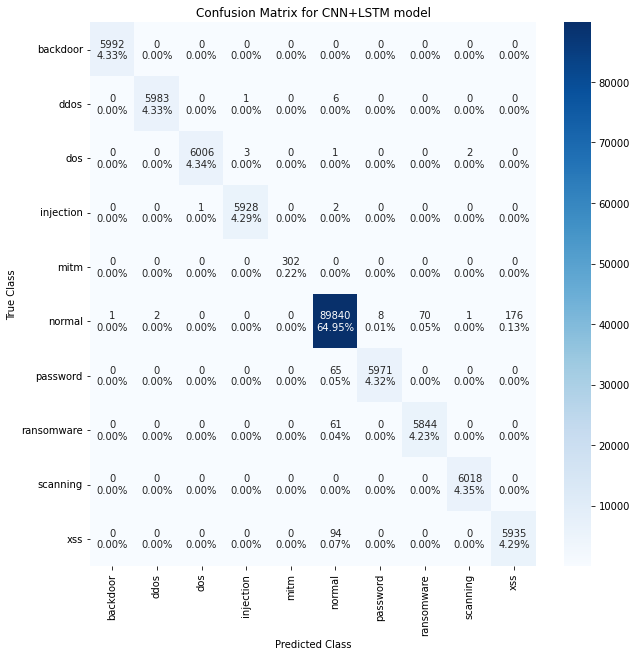

              precision    recall  f1-score   support

    backdoor     0.9998    1.0000    0.9999      5992
        ddos     0.9997    0.9988    0.9992      5990
         dos     0.9998    0.9990    0.9994      6012
   injection     0.9993    0.9995    0.9994      5931
        mitm     1.0000    1.0000    1.0000       302
      normal     0.9975    0.9971    0.9973     90098
    password     0.9987    0.9892    0.9939      6036
  ransomware     0.9882    0.9897    0.9889      5905
    scanning     0.9995    1.0000    0.9998      6018
         xss     0.9712    0.9844    0.9778      6029

    accuracy                         0.9964    138313
   macro avg     0.9954    0.9958    0.9956    138313
weighted avg     0.9964    0.9964    0.9964    138313

4323/4323 [==============================] - 44s 10ms/step - loss: 2.3045e-04 - accuracy: 0.9964
Test: accuracy = 0.996428  ;  loss = 0.000230


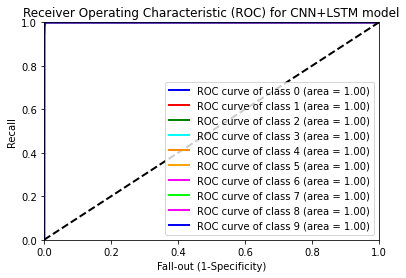

In [57]:
# Evaluation Metrics of CNN-LSTM model

eval_metrics(model1, model1Name)



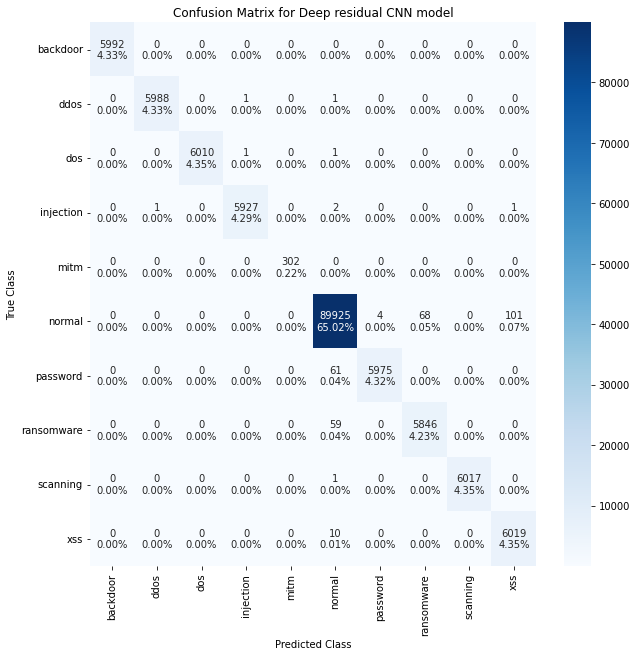

              precision    recall  f1-score   support

    backdoor     1.0000    1.0000    1.0000      5992
        ddos     0.9998    0.9997    0.9997      5990
         dos     1.0000    0.9997    0.9998      6012
   injection     0.9997    0.9993    0.9995      5931
        mitm     1.0000    1.0000    1.0000       302
      normal     0.9985    0.9981    0.9983     90098
    password     0.9993    0.9899    0.9946      6036
  ransomware     0.9885    0.9900    0.9893      5905
    scanning     1.0000    0.9998    0.9999      6018
         xss     0.9833    0.9983    0.9908      6029

    accuracy                         0.9977    138313
   macro avg     0.9969    0.9975    0.9972    138313
weighted avg     0.9978    0.9977    0.9977    138313

4323/4323 [==============================] - 30s 7ms/step - loss: 1.3823e-04 - accuracy: 0.9977
Test: accuracy = 0.997744  ;  loss = 0.000138


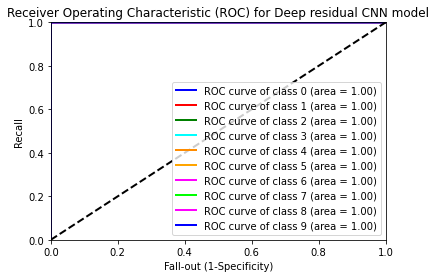

In [58]:
# Evaluation Metrics of Deep residual CNN model


eval_metrics(model2, model2Name)

### Results

####The overall accuracy and loss calculated while testing the model:


**1.   CNN-LSTM Model**

*   Accuracy - 99.64%
*   Loss - 0.023%


**2.   DRCNN Model**

*   Accuracy - 99.77%
*   Loss - 0.013%


